## Feature Engineering

This notebook is separated into two sections: feature engineering and exploratory data analysis. A summary of the findings is given below and again at the very end of the notebook. <br>

## Summary of Data Exploration

1) Breed: Pit bulls are more likely to die in an animal shelter than other breeds. <br>
2) Color: Color does not appear to be a significant factor in determining the outcome of the animal. <br>
3) Spay/Neuter Status: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Aletered animals are more likely to be adopted, but this may be due to how the animal center processes dogs before putting them up for adoption. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Intact animals with a name are likely to be returned to owner, most likely because these animals are strays with a nametag or a microchip. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Intact animals in general have a high transfer rate. It would be interest to investigate this further; my best guess is that the shelter was full at the time and had to transfer animals to other shelters. <br>
4) Sex: Sex does not appear to be a significant factor in determining the outcome of the animal. <br>
5) Age Range: Young dogs are very likely to be adopted, whereas old dogs are relatively more likely to be returned to owner or die in the shelter. <br>
6) Stray Hold: Most animals in the stray hold program end up adopted or transferred.

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Set graphics styles.
sns.set(style = 'whitegrid', context = 'notebook', palette = 'deep')

In [2]:
#Import the data.
dataset = pd.read_csv(r"C:\Users\Patrick\Desktop\ShelterOutcomes2\Austin_Animal_Center_Outcomes_clean.csv")

#Look for missing data.
dataset.isnull().sum()

Animal ID           0
Name             8876
Outcome Type        0
Breed               0
Color               0
Year of Birth       0
Altered             1
Sex                 1
dtype: int64

In [3]:
#Add in missing data elements.
dataset.loc[37033, 'Altered'] = 'Unknown'
dataset.loc[37033, 'Sex'] = 'Male'

Some dogs have an asterisk in front of their name. This means that the dog is no longer on stray-hold and is up for adoption.

In [4]:
#Not every dog will have a name; keep track of those that do.
def has_name(name):
    """
    Returns true if the dog has a name; else, returns false.
    """
    if pd.isnull(name):
        return 0
    else:
        return 1

In [5]:
#Keep track of animals on stray hold.
def stray_hold(name):
    """
    Returns 1 if the dog was on stray hold.
    """
    if str(name)[0] == '*':
        return 1
    else:
        return 0

In [6]:
#The year of birth of the dog is not completely accurate. Keep track only of the relative age range of the dog.
def age_range(year):
    """
    Returns whether the dog is a puppy, adult, or senior given its year of birth.
    """
    if year > 2014:
        return 'Young'
    elif year >= 2009:
        return 'Adult'
    else:
        return 'Senior'

In [7]:
#Determine whether dogs are of mixed breed or of mixed color.
def mixed_attr(attr):
    """
    Returns whether an attribute of a dog is mixed or not.
    """
    if 'mix' in attr.lower() or '/' in attr:
        return 1
    else:
        return 0

In [8]:
#Look at the count and frequency by breed. This will be used to collapse infrequent breeds into a single breed category.
pvt = pd.pivot_table(dataset
                     , index = 'Breed'
                     , values = 'Animal ID'
                     , aggfunc = pd.Series.nunique)
pvt['Frequency'] = round(pvt['Animal ID'] / pvt['Animal ID'].sum() * 100, 2)
print(pvt
      .sort_values(by = 'Frequency'
                  , ascending = False)
      .to_string())

                                                    Animal ID  Frequency
Breed                                                                   
Pit Bull Mix                                             5901      12.81
Chihuahua Shorthair Mix                                  5109      11.09
Labrador Retriever Mix                                   4932      10.70
German Shepherd Mix                                      2052       4.45
Australian Cattle Dog Mix                                1094       2.37
Dachshund Mix                                             846       1.84
Boxer Mix                                                 673       1.46
Border Collie Mix                                         665       1.44
Miniature Poodle Mix                                      650       1.41
Australian Shepherd Mix                                   510       1.11
Yorkshire Terrier Mix                                     509       1.10
Catahoula Mix                                      

In [9]:
#Look at the count and frequency by color. This will be used to collapse infrequent colors into a single color category.
pvt = pd.pivot_table(dataset
                     , index = 'Color'
                     , values = 'Animal ID'
                     , aggfunc = pd.Series.nunique)
pvt['Frequency'] = round(pvt['Animal ID'] / pvt['Animal ID'].sum() * 100, 2)
print(pvt
      .sort_values(by = 'Frequency'
                  , ascending = False)
      .to_string())

                             Animal ID  Frequency
Color                                            
Black/White                       5253      11.40
Black                             2554       5.54
Brown/White                       2506       5.44
Tan/White                         2489       5.40
White                             2481       5.38
Tan                               2086       4.53
Tricolor                          1922       4.17
Brown                             1889       4.10
Black/Tan                         1839       3.99
White/Black                       1567       3.40
Black/Brown                       1524       3.31
White/Brown                       1522       3.30
Brown Brindle/White               1321       2.87
Blue/White                        1270       2.76
White/Tan                         1189       2.58
Brown/Black                       1140       2.47
Red                                896       1.94
Red/White                          856       1.86


In [10]:
#Look at the count and frequency of outcome types. This will be used to map rare outcome types into a single outcome type. 
pvt = pd.pivot_table(dataset
                     , index = 'Outcome Type'
                     , values = 'Animal ID'
                     , aggfunc = pd.Series.nunique)
pvt['Frequency'] = round(pvt['Animal ID'] / pvt['Animal ID'].sum() * 100, 2)
print(pvt
      .sort_values(by = 'Frequency'
                  , ascending = False)
      .to_string())

                 Animal ID  Frequency
Outcome Type                         
Adoption             22041      44.99
Return to Owner      13345      27.24
Transfer             11555      23.59
Euthanasia            1578       3.22
Rto-Adopt              263       0.54
Died                   177       0.36
Missing                 17       0.03
Disposal                10       0.02


In [11]:
#For a given column, map infrequent occurences to a 'Rare' category.
def map_to_rare(source_data, attr, threshold, new_value):
    """
    First gets the primary attribute (e.g. if color is white/brown, returns white. 
    Then, maps infrequent values to a 'Rare' category.
    """
    source_data[attr] = source_data[attr].str.split('/', n = 1, expand = True)[0].map(lambda x: x.strip())
    source_data[attr] = source_data[attr].map(lambda x: x[:-4].strip() if ' Mix' in x else x)
    pvt = pd.pivot_table(dataset
                     , index = attr
                     , values = 'Animal ID'
                     , aggfunc = pd.Series.nunique)
    pvt['Frequency'] = round(pvt['Animal ID'] / pvt['Animal ID'].sum() * 100, 2)
    source_data[attr] = source_data[attr].map(lambda x: x if pvt.Frequency[x] > threshold else new_value)
    return source_data[attr]

In [12]:
#Apply all functions to the data.
dataset['HasName'] = dataset['Name'].apply(has_name)
dataset['AgeRange'] = dataset['Year of Birth'].apply(age_range)
dataset['MixedBreed'] = dataset['Breed'].apply(mixed_attr)
dataset['MixedColor'] = dataset['Color'].apply(mixed_attr)
dataset['StrayHold'] = dataset['Name'].apply(stray_hold)
threshold = 2.9
dataset['Breed'] = map_to_rare(dataset, 'Breed', 2.9, 'Rare')
dataset['Color'] = map_to_rare(dataset, 'Color', 2.9, 'Rare')
dataset['Outcome Type'] = map_to_rare(dataset, 'Outcome Type', 4, 'Died')

In [13]:
#Delete columns no longer in use.
to_drop = ['Name', 'Year of Birth']
for col in to_drop:
    dataset.drop(col, axis = 1, inplace = True)

In [14]:
#Export the data.
dataset.to_csv(path_or_buf = r"C:\Users\Patrick\Desktop\ShelterOutcomes2\Austin_Animal_Center_Outcomes_FE.csv"
               , index = False)

## Exploratory Data Analysis

In [40]:
def plot_outcome_by_attribute(source_data, attr):
    """
    Creates a 100% stacked bar graph, where the bins are the unique values of the attribute (e.g. for sex: Male,
    Female, and Unknown), the heights of the bars are 1, and the bars are separated by outcome types.
    """
    
    #Create a pivot table to group the data.
    pvt = pd.pivot_table(data = source_data
                , values = ['Animal ID']
                , index = [attr]
                , columns = ['Outcome Type']
                , aggfunc = pd.Series.nunique)
    #Turn the counts into frequencies.
    pvt = pvt.div(pvt.sum(1), axis = 0)
    #Plot the resulting stacked 100% bar graph.
    return pvt.plot(kind = 'bar'
            , stacked = True
            , title = 'Outcomes by ' + attr
            , legend = False).legend(loc = 'center left', bbox_to_anchor=(1.0, 0.5))

SyntaxError: positional argument follows keyword argument (<ipython-input-40-26346bcf76ad>, line 19)

In [38]:
dataset.columns

Index(['Animal ID', 'Outcome Type', 'Breed', 'Color', 'Altered', 'Sex',
       'HasName', 'AgeRange', 'MixedBreed', 'MixedColor', 'StrayHold'],
      dtype='object')

### Breed

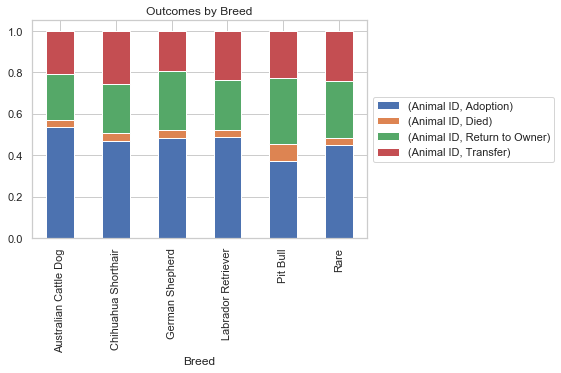

In [39]:
plot_outcome_by_attribute(dataset, 'Breed')

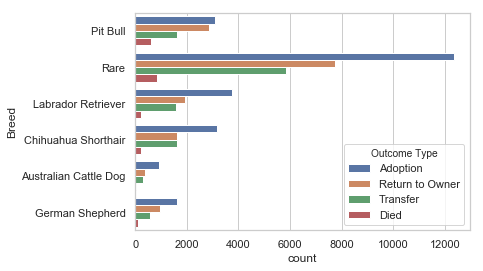

In [18]:
sns.countplot(data = dataset
              , y = 'Breed'
              , hue = 'Outcome Type')

It looks like pit bulls are more likely to die or be returned to owner than other breeds. It also appears that shorthair chihuahuas are more likely to be transferred than another breeds. Otherwise, the outcomes don't appear to vary much by breed.

### Color

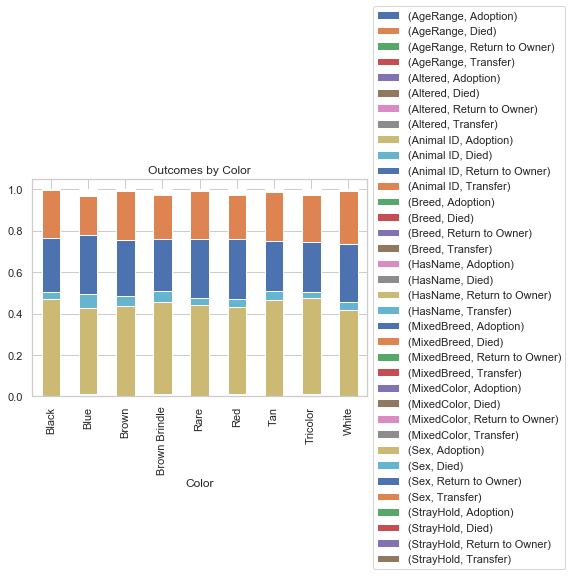

In [19]:
plot_outcome_by_attribute(dataset, 'Color')

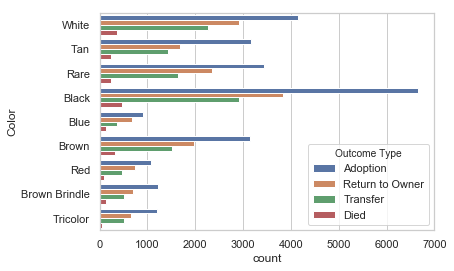

In [20]:
sns.countplot(data = dataset
              , y = 'Color'
              , hue = 'Outcome Type')

Color doens't seem to be a significant factor in determining the outcome of the animal.

### Spay/Neuter Status

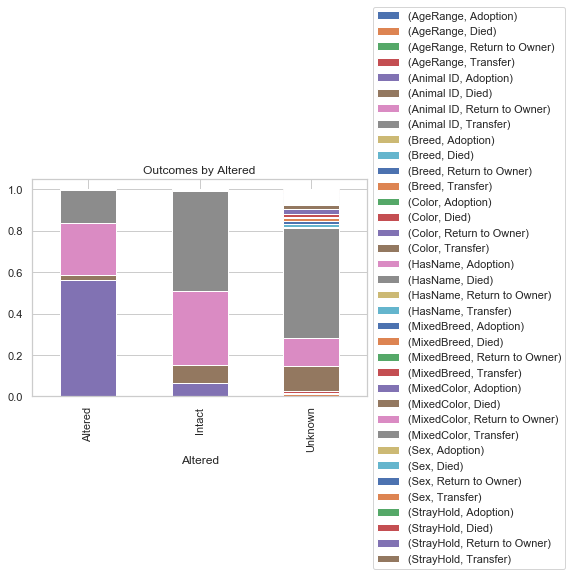

In [21]:
plot_outcome_by_attribute(dataset, 'Altered')

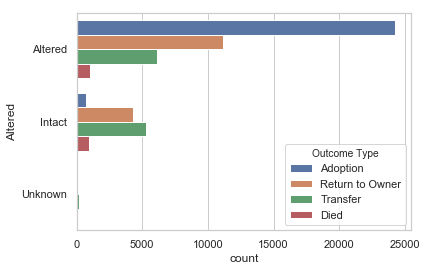

In [22]:
sns.countplot(data = dataset
              , y = 'Altered'
              , hue = 'Outcome Type')

Altered animals have a much higher rate of being adopted. This is to be expected: animal shelters tend to spay/neuter animals before putting them up for adoption. Let's focus on intact animals next.

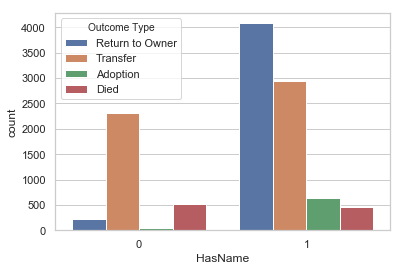

In [23]:
sns.countplot(data = dataset[dataset['Altered'] == 'Intact']
             , x = 'HasName'
             , hue = 'Outcome Type')

Intact animals without a name are most likely to be transferred. My best guess is that these dogs don't stay at the shelter long. <br><br>

A large number of intact animals, whether or not they have a name, are also transferred.

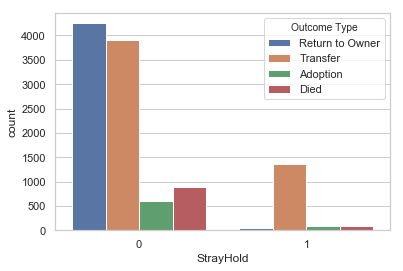

In [24]:
sns.countplot(data = dataset[dataset['Altered'] == 'Intact']
             , x = 'StrayHold'
             , hue = 'Outcome Type')

Intact stray hold animals are more likely to be transferred. There are a relatievly small number of these animals (between 1000 and 1500). For intact animals not on stray hold, they're most likely to be returned to owner or transferred.

### Sex

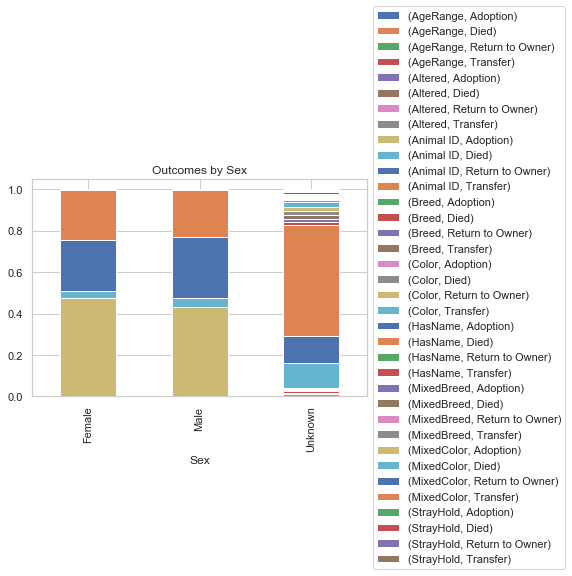

In [25]:
plot_outcome_by_attribute(dataset, 'Sex')

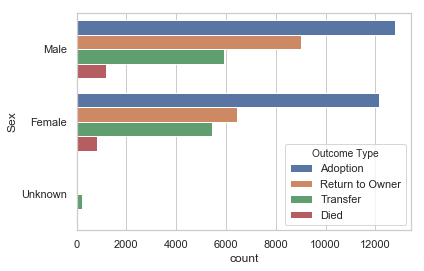

In [26]:
sns.countplot(data = dataset
              , y = 'Sex'
              , hue = 'Outcome Type')

It seems that male dogs are slightly more likely to die or be returned to owner than female dogs, and female dogs are slightly more likely to be transferred. This difference is relatively small, however.

### Has Name

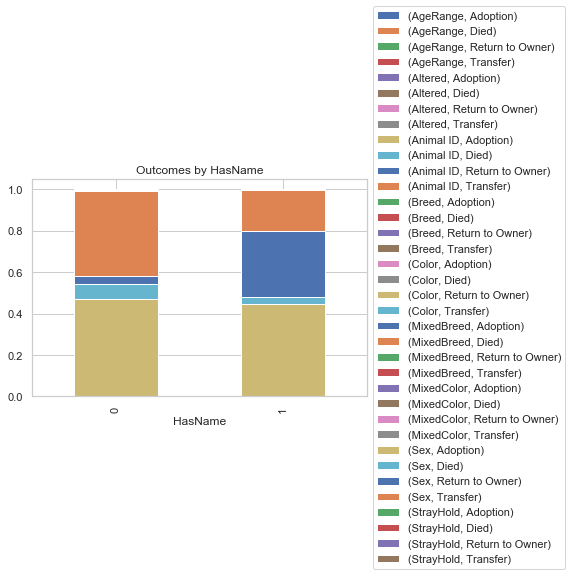

In [27]:
plot_outcome_by_attribute(dataset, 'HasName')

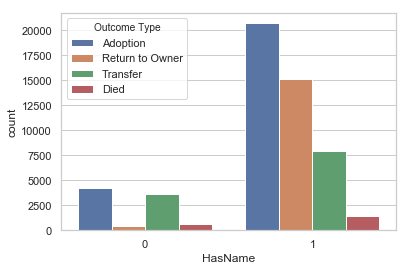

In [28]:
sns.countplot(data = dataset
              , x = 'HasName'
              , hue = 'Outcome Type')

Animals without a name are likely to be adopted or transferred. <br><br>

Because there are relatively few animals that don't have a name, it's difficult to draw conclusion between those dogs that have a name and those dogs that don't have a name.

### Age Range

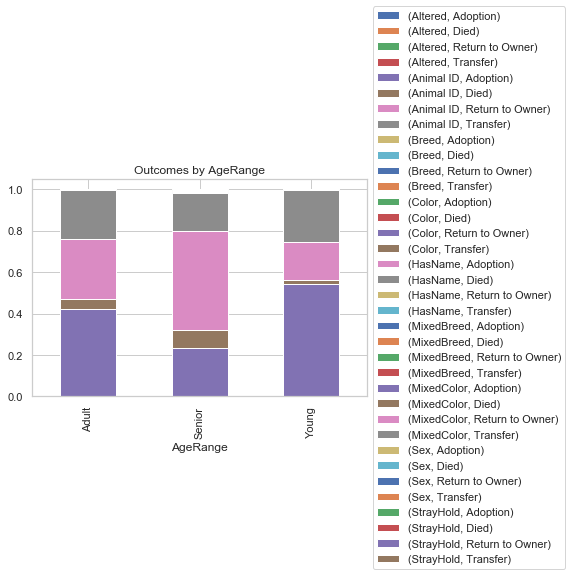

In [29]:
plot_outcome_by_attribute(dataset, 'AgeRange')

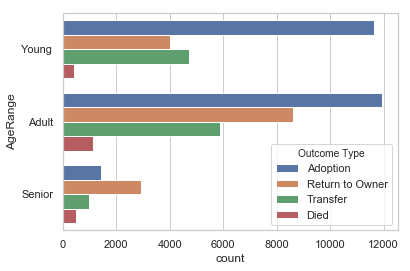

In [30]:
sns.countplot(data = dataset
              , y = 'AgeRange'
              , hue = 'Outcome Type')

As expected, age range plays a huge factor in the outcome of the animal: young dogs are much more likely to be adopted. Senior dogs are much more likely to be returned to owner or die compared to young and adult dogs.

### Mixed Attributes

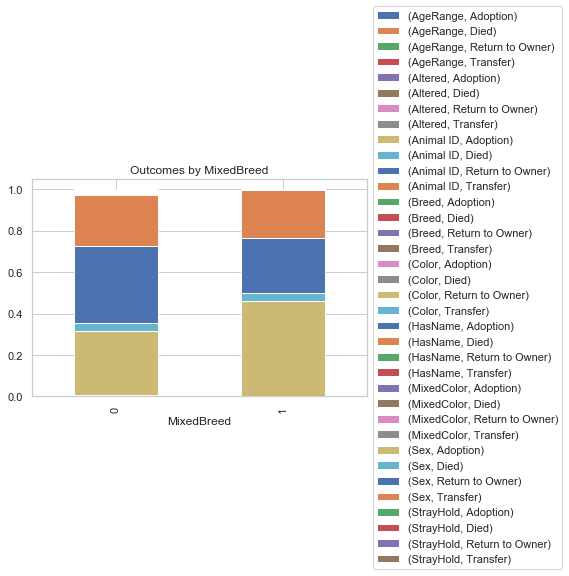

In [31]:
plot_outcome_by_attribute(dataset, 'MixedBreed')

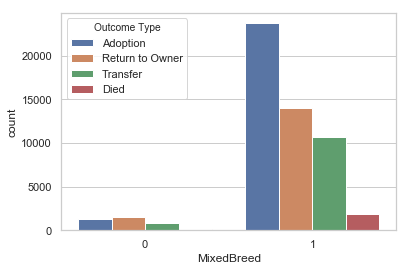

In [32]:
sns.countplot(data = dataset
              , x = 'MixedBreed'
              , hue = 'Outcome Type')

There are relatively few pure bred dogs, so it's difficult to draw a conclusion between mixed breed and pure breed.

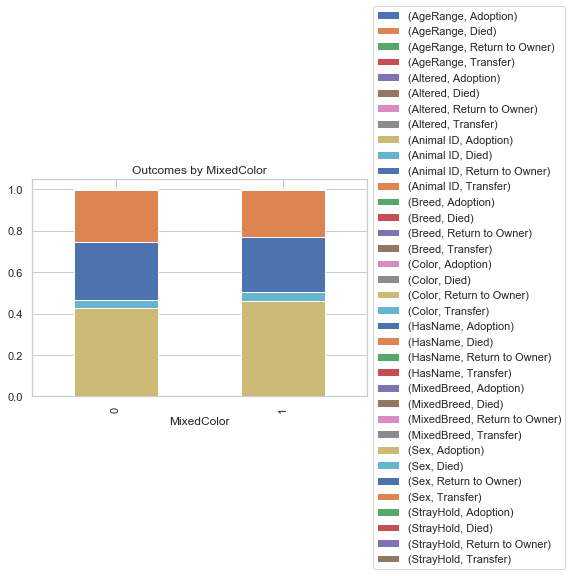

In [33]:
plot_outcome_by_attribute(dataset, 'MixedColor')

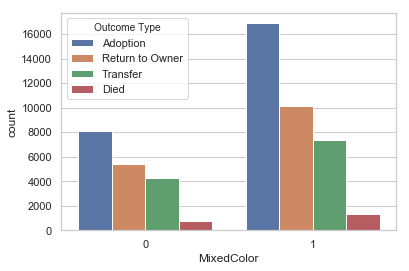

In [34]:
sns.countplot(data = dataset
              , x = 'MixedColor'
              , hue = 'Outcome Type')

Being of mixed color does not appear to be a significant factor in determining the outcome of the animal.

### Stray Hold

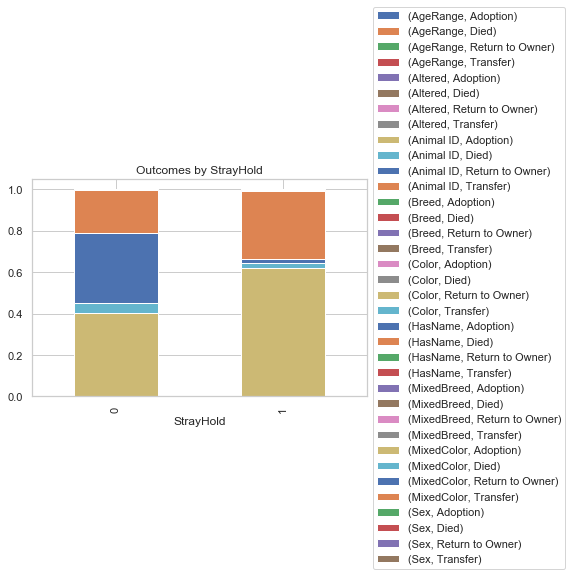

In [35]:
plot_outcome_by_attribute(dataset, 'StrayHold')

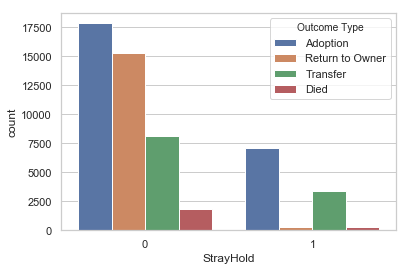

In [36]:
sns.countplot(data = dataset
              , x = 'StrayHold'
              , hue = 'Outcome Type')

About 20% of the animals come from the stray hold program. Almost all of them are adopted or transferred.

## Summary of Data Exploration

1) Breed: Pit bulls are more likely to die in an animal shelter than other breeds. <br>
2) Color: Color does not appear to be a significant factor in determining the outcome of the animal. <br>
3) Spay/Neuter Status: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Aletered animals are more likely to be adopted, but this may be due to how the animal center processes dogs before putting them up for adoption. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Intact animals with a name are likely to be returned to owner, most likely because these animals are strays with a nametag or a microchip. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Intact animals in general have a high transfer rate. It would be interest to investigate this further; my best guess is that the shelter was full at the time and had to transfer animals to other shelters. <br>
4) Sex: Sex does not appear to be a significant factor in determining the outcome of the animal. <br>
5) Age Range: Young dogs are very likely to be adopted, whereas old dogs are relatively more likely to be returned to owner or die in the shelter. <br>
6) Stray Hold: Most animals in the stray hold program end up adopted or transferred.